# Instituto Tecnológico de Costa Rica

### Escuela de Ingeniería en Computación

### Maestría Académica en Ciencias de la Computación

### Curso: Aprendizaje Automático (Machine Learning)

# Proyecto Final
- Multivariate Exogenous Time Series Modeling for Real-Time Pump Pressure Forecasting
## Estudiantes:
- Emmanuel Rosales Salas - 2013108931
- Alejandro Arroyo Valle - 2016108971

# Carga de Bibliotecas y Dataset

## Instalar las bibliotecas necesarias

In [41]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn statsmodels pmdarima xgboost lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importación de la clases

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.model_selection import RandomizedSearchCV

## Importar los datos.

In [43]:
raw_dataset = pd.read_csv('multi_data_01.csv', header = 0, parse_dates = [0], index_col = 0)

## Algunos datos estan desordenados, los ordenamos por fecha
raw_dataset = raw_dataset.sort_index()

## Para pruenas, reducir el tamaÑo del dataset
lite_size = int(len(raw_dataset) * 0.01)
raw_dataset = raw_dataset.iloc[:lite_size]

raw_dataset.head()

,runautomode_bool,actual_speed_m_min,secundary_pumpspeed_rpm,secundary_pa16d1_bar,secundary_p014d1_bar,secundary_p015d1_bar,secundary_pa7b3_mm,secundary_pa4b2_c,secundary_pa4b5_c,secundary_pu2b2_c,...,primary_p015d1_bar,primary_pa7b3_mm,primary_pa4b2_c,primary_pa4b5_c,primary_pu2b2_c,primary_p012b3_c,primary_p022b3_c,primary_pa16d6_c,primary_p014d6_c,primary_p015d6_c
date_time,,,,,,,,,,,,,,,,,,,,,
2023-06-22 14:16:06.761126,t,3.5,21.589945,33.216620,94.21156,57.346170,34.467407,99.9,103.2,99.8,...,78.950264,225.65234,102.0,99.7,100.4,86.9,100.2,869.9,100.2,105.3
2023-06-22 14:16:12.104136,t,3.5,21.516739,33.197170,94.46119,57.368862,34.337220,99.9,103.2,99.8,...,75.478180,226.00946,101.9,99.7,100.4,86.8,100.1,869.9,100.1,105.1
2023-06-22 14:16:17.457427,t,3.5,21.919836,33.122610,94.12079,57.312130,34.402344,99.9,103.1,99.8,...,81.038055,225.94452,101.8,99.7,100.4,86.4,100.2,869.9,100.0,105.1
2023-06-22 14:16:25.906595,t,3.5,21.708180,33.070736,94.32503,57.266743,34.272156,99.9,103.1,99.8,...,79.222590,225.84710,101.7,99.9,100.2,86.9,100.2,869.9,99.9,104.8
2023-06-22 14:16:33.827435,t,3.5,21.853577,33.161510,94.35907,57.391556,34.239563,99.9,103.1,99.8,...,75.841270,225.42505,101.6,99.9,100.2,86.9,100.2,869.9,99.8,104.6


# Exploración de Datos

## Contexto de los datos

![Texto alternativo](image005.png)
![Texto alternativo](drum_press.jpg)

Este dataset contiene datos de dos máquinas de producción, estas máquinas son prensas hidráulicas que bombean material adhesivo sobre una lámina plástica, similares a la imagen anterior. Además del timestamp, las columnas representan valores de diferentes sensores que tiene cada prensa.

En el nombre de cada columna hay un sufijo que describe si el valor corresponde a la prensa "secundary" o "primary". Después de este sufijo, se especifíca el nombre del sensor que está siendo leído, finalmente los nombres de las columnas termina con la unidad de la variable en cuestión.

El nombre del sensor se puede referenciar en la primer imagen.

In [44]:
print("Descripción del Dataset");
raw_dataset.describe()

Descripción del Dataset


,actual_speed_m_min,secundary_pumpspeed_rpm,secundary_pa16d1_bar,secundary_p014d1_bar,secundary_p015d1_bar,secundary_pa7b3_mm,secundary_pa4b2_c,secundary_pa4b5_c,secundary_pu2b2_c,secundary_p012b3_c,...,primary_p015d1_bar,primary_pa7b3_mm,primary_pa4b2_c,primary_pa4b5_c,primary_pu2b2_c,primary_p012b3_c,primary_p022b3_c,primary_pa16d6_c,primary_p014d6_c,primary_p015d6_c
count,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,...,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9.397000e+03,9397.000000,9397.000000
mean,4.492902,35.818763,30.458714,101.212996,62.641639,314.947707,99.736533,103.333968,99.672502,95.968841,...,87.276038,342.850722,105.270863,107.991657,106.669969,92.322912,99.630584,8.699000e+02,97.705225,107.311525
std,3.198190,26.695791,4.789479,46.387289,35.740028,161.025781,1.535649,1.784824,1.741329,3.268498,...,42.516571,202.363932,128.492161,71.626011,71.617155,73.018849,2.151974,1.136929e-13,3.571811,8.984200
min,0.000000,0.000000,4.065357,4.810996,-0.839655,6.672119,86.800000,88.800000,85.300000,73.400000,...,0.056733,2.597412,-200.000000,97.800000,92.900000,64.000000,81.900000,8.699000e+02,83.900000,78.700000
25%,0.000000,2.376815,29.456007,57.312130,30.976461,169.082400,99.900000,103.300000,99.900000,94.300000,...,47.202230,177.437380,102.200000,99.900000,99.800000,83.900000,99.800000,8.699000e+02,95.600000,100.900000
50%,6.500000,41.965610,29.990921,128.081440,83.284700,317.041750,100.000000,103.700000,100.000000,96.200000,...,107.385070,304.094900,104.100000,100.000000,100.000000,85.600000,99.900000,8.699000e+02,97.800000,108.100000
75%,6.984551,56.285040,33.287945,137.272250,90.512540,465.228940,100.100000,103.900000,100.100000,97.900000,...,120.342990,506.467740,105.300000,100.200000,100.200000,87.400000,100.200000,8.699000e+02,100.300000,113.200000
max,7.800000,80.000000,36.393696,255.788420,219.910190,730.195300,100.800000,105.600000,101.100000,102.500000,...,196.558700,972.999940,869.900000,869.900000,869.900000,869.900000,101.500000,8.699000e+02,106.100000,274.700000


In [45]:
print(f"Las dimensiones del dataset son (filas, columnas): {raw_dataset.shape}")

Las dimensiones del dataset son (filas, columnas): (9397, 29)


In [46]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9397 entries, 2023-06-22 14:16:06.761126 to 2023-06-23 03:31:56.228891
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   runautomode_bool             9397 non-null   object 
 1   actual_speed_m_min           9397 non-null   float64
 2   secundary_pumpspeed_rpm      9397 non-null   float64
 3   secundary_pa16d1_bar         9397 non-null   float64
 4   secundary_p014d1_bar         9397 non-null   float64
 5   secundary_p015d1_bar         9397 non-null   float64
 6   secundary_pa7b3_mm           9397 non-null   float64
 7   secundary_pa4b2_c            9397 non-null   float64
 8   secundary_pa4b5_c            9397 non-null   float64
 9   secundary_pu2b2_c            9397 non-null   float64
 10  secundary_p012b3_c           9397 non-null   float64
 11  secundary_p022b3_c           9397 non-null   float64
 12  secundary_pa16d6_c        

## Gráficos

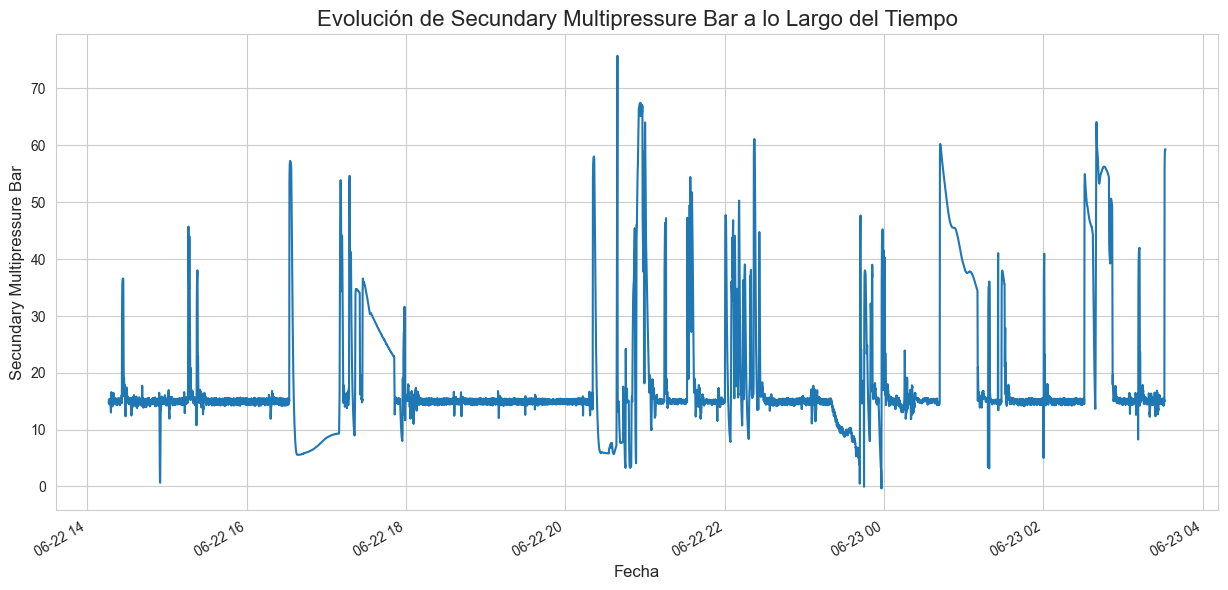

In [47]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7) # Aumentar el tamaño del gráfico

raw_dataset['secundary_multipressure_bar'].plot()

# Añadir títulos y etiquetas para mayor claridad
plt.title('Evolución de Secundary Multipressure Bar a lo Largo del Tiempo', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Secundary Multipressure Bar', fontsize=12)
plt.show()

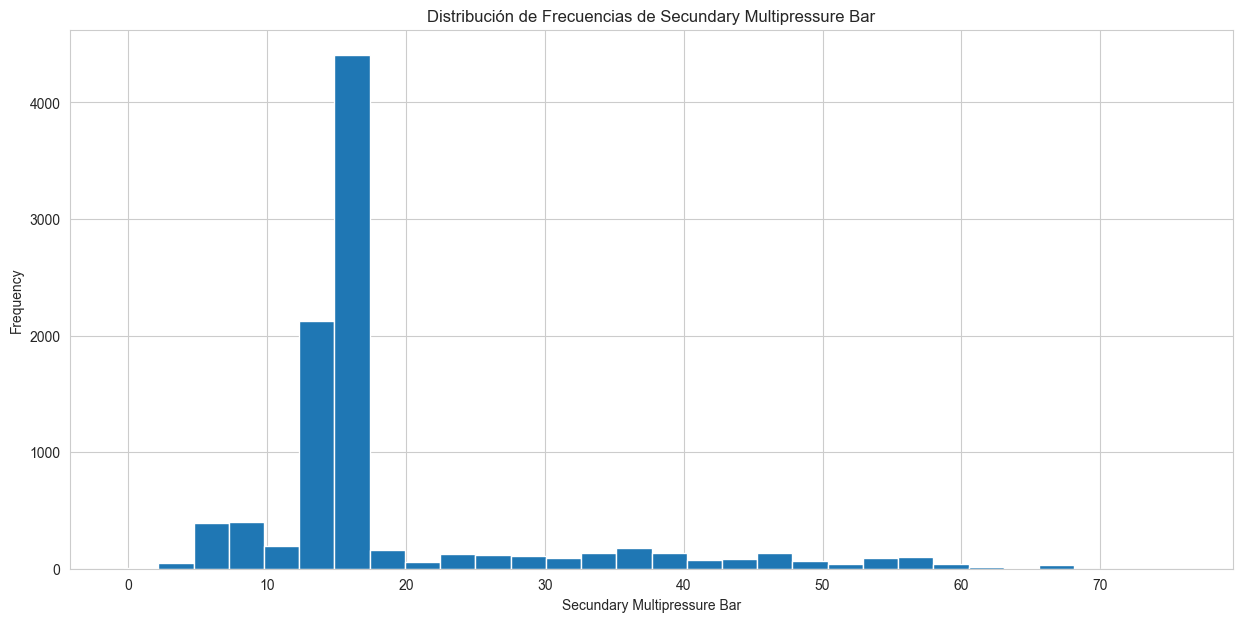

In [48]:
raw_dataset['secundary_multipressure_bar'].plot(kind='hist', bins=30, title='Distribución de Frecuencias de Secundary Multipressure Bar')
plt.xlabel('Secundary Multipressure Bar')
plt.show()

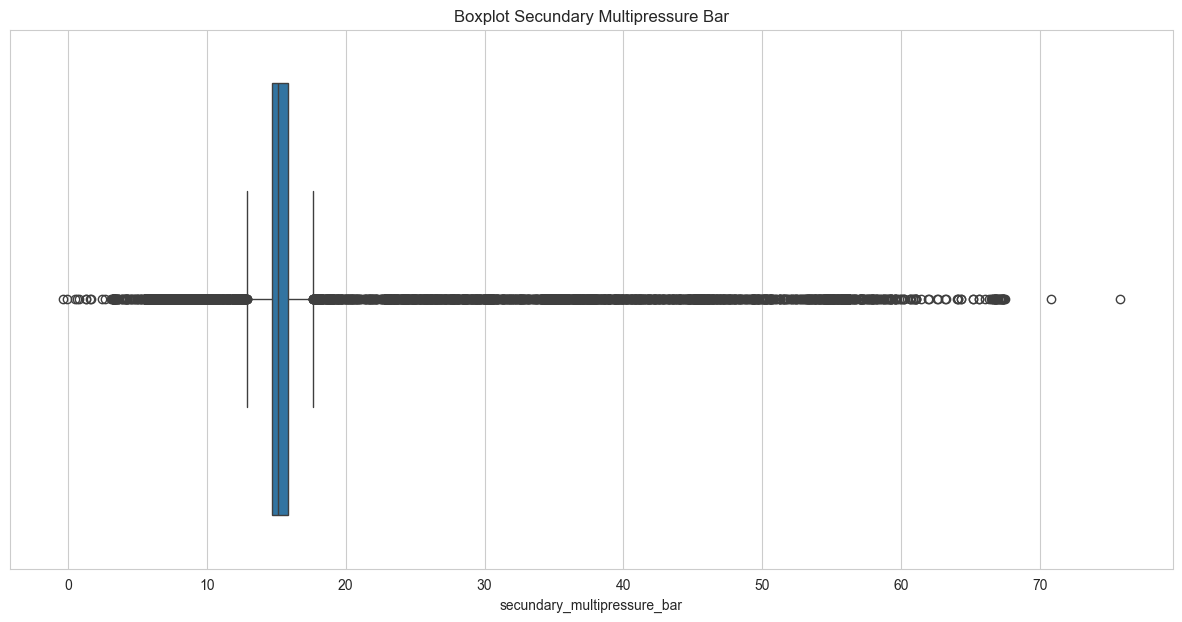

In [49]:
sns.boxplot(x=raw_dataset['secundary_multipressure_bar'])
plt.title('Boxplot Secundary Multipressure Bar')
plt.show()

# Preprocesamiento de Datos

## Eliminación de las columnas primary

Dada la naturaleza de nuestro proyecto, queremos predecir la variable secundary_multipressure_bar, por esta razón, todas las caracterísiticas que influyen en ella son las que tienen como pre fijos "secundary". Por esta razón, las columnas que son de primary, no son necesarias para nuestra predicción, por lo tanto procedemos a eliminarlas.

In [50]:
# Eliminar las columnas relacionadas con primary

# Primero se obtienen los nombres de las columnas que contienen 'primary'
primary_columns = raw_dataset.filter(like = 'primary').columns

# Eliminamos las columnas del DataFrame
processed_dataset = raw_dataset.drop(columns = primary_columns)

# Imprimir la cantidad de columnas eliminadas y las primeras filas del nuevo DataFrame
print("\nDataFrame después de eliminar las columnas:")
print(f"Se eliminaron {len(primary_columns)}")
processed_dataset.head()



DataFrame después de eliminar las columnas:
Se eliminaron 13


,runautomode_bool,actual_speed_m_min,secundary_pumpspeed_rpm,secundary_pa16d1_bar,secundary_p014d1_bar,secundary_p015d1_bar,secundary_pa7b3_mm,secundary_pa4b2_c,secundary_pa4b5_c,secundary_pu2b2_c,secundary_p012b3_c,secundary_p022b3_c,secundary_pa16d6_c,secundary_p014d6_c,secundary_p015d6_c,secundary_multipressure_bar
date_time,,,,,,,,,,,,,,,,
2023-06-22 14:16:06.761126,t,3.5,21.589945,33.216620,94.21156,57.346170,34.467407,99.9,103.2,99.8,94.9,100.1,102.2,95.8,110.7,14.624008
2023-06-22 14:16:12.104136,t,3.5,21.516739,33.197170,94.46119,57.368862,34.337220,99.9,103.2,99.8,94.9,100.3,102.2,95.8,110.6,14.967206
2023-06-22 14:16:17.457427,t,3.5,21.919836,33.122610,94.12079,57.312130,34.402344,99.9,103.1,99.8,94.8,100.2,102.2,95.8,110.4,15.272269
2023-06-22 14:16:25.906595,t,3.5,21.708180,33.070736,94.32503,57.266743,34.272156,99.9,103.1,99.8,94.7,99.6,102.2,95.8,110.2,14.776541
2023-06-22 14:16:33.827435,t,3.5,21.853577,33.161510,94.35907,57.391556,34.239563,99.9,103.1,99.8,94.6,99.8,102.2,95.8,109.9,15.234137


## Verificación de la columna de tiempo este en el formato y tipo correcto

In [51]:
# Validar el tipo de la columna de tiempo sea el indice
print(processed_dataset.index)

DatetimeIndex(['2023-06-22 14:16:06.761126', '2023-06-22 14:16:12.104136',
               '2023-06-22 14:16:17.457427', '2023-06-22 14:16:25.906595',
               '2023-06-22 14:16:33.827435', '2023-06-22 14:16:38.907547',
               '2023-06-22 14:16:43.990893', '2023-06-22 14:16:49.089285',
               '2023-06-22 14:16:54.170175', '2023-06-22 14:16:59.267724',
               ...
               '2023-06-23 03:31:09.961138', '2023-06-23 03:31:15.034108',
               '2023-06-23 03:31:20.123719', '2023-06-23 03:31:25.203902',
               '2023-06-23 03:31:30.271526', '2023-06-23 03:31:35.341918',
               '2023-06-23 03:31:40.423970', '2023-06-23 03:31:45.943964',
               '2023-06-23 03:31:51.116377', '2023-06-23 03:31:56.228891'],
              dtype='datetime64[ns]', name='date_time', length=9397, freq=None)


In [52]:
#Validamos si la columna de tiempo está en el formato correcto
print(f"Tipo de dato: {processed_dataset.index.dtype}")


Tipo de dato: datetime64[ns]


## Verificación de valores nulos

Las series de tiempo no pueden procesar valores nulos, por lo cual validamos que no existan

In [53]:
# Valorizamos si existen valores nulos en el dataset
null_values = processed_dataset.isnull().sum()
print("\nValores nulos por columna:")
print(null_values)


Valores nulos por columna:
runautomode_bool               0
actual_speed_m_min             0
secundary_pumpspeed_rpm        0
secundary_pa16d1_bar           0
secundary_p014d1_bar           0
secundary_p015d1_bar           0
secundary_pa7b3_mm             0
secundary_pa4b2_c              0
secundary_pa4b5_c              0
secundary_pu2b2_c              0
secundary_p012b3_c             0
secundary_p022b3_c             0
secundary_pa16d6_c             0
secundary_p014d6_c             0
secundary_p015d6_c             0
secundary_multipressure_bar    0
dtype: int64


## Procesamiento de variable categórica.

Nuestro dataset presenta una variable categórica (runautomode_bool), la cual indica si la máquina esta funcionando o no, al ser un valor booleano, debemos procesarla como variable ordinal, ya que el valor true o 1 significa que la máquina esta funcionando y false o 0, que la máquina no esta funcionando, lo que hace que cuantitativamente 1 sea más que 0.

In [54]:
encoder = LabelEncoder()
processed_dataset['runautomode_bool'] = encoder.fit_transform(processed_dataset['runautomode_bool'])
processed_dataset.head()

,runautomode_bool,actual_speed_m_min,secundary_pumpspeed_rpm,secundary_pa16d1_bar,secundary_p014d1_bar,secundary_p015d1_bar,secundary_pa7b3_mm,secundary_pa4b2_c,secundary_pa4b5_c,secundary_pu2b2_c,secundary_p012b3_c,secundary_p022b3_c,secundary_pa16d6_c,secundary_p014d6_c,secundary_p015d6_c,secundary_multipressure_bar
date_time,,,,,,,,,,,,,,,,
2023-06-22 14:16:06.761126,1,3.5,21.589945,33.216620,94.21156,57.346170,34.467407,99.9,103.2,99.8,94.9,100.1,102.2,95.8,110.7,14.624008
2023-06-22 14:16:12.104136,1,3.5,21.516739,33.197170,94.46119,57.368862,34.337220,99.9,103.2,99.8,94.9,100.3,102.2,95.8,110.6,14.967206
2023-06-22 14:16:17.457427,1,3.5,21.919836,33.122610,94.12079,57.312130,34.402344,99.9,103.1,99.8,94.8,100.2,102.2,95.8,110.4,15.272269
2023-06-22 14:16:25.906595,1,3.5,21.708180,33.070736,94.32503,57.266743,34.272156,99.9,103.1,99.8,94.7,99.6,102.2,95.8,110.2,14.776541
2023-06-22 14:16:33.827435,1,3.5,21.853577,33.161510,94.35907,57.391556,34.239563,99.9,103.1,99.8,94.6,99.8,102.2,95.8,109.9,15.234137


## Selección de Features

### Mutual Information

In [55]:
X = processed_dataset.drop(columns=["secundary_multipressure_bar"])
y = processed_dataset["secundary_multipressure_bar"]

mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)


secundary_p014d1_bar       0.990422
secundary_p015d1_bar       0.947875
secundary_pa7b3_mm         0.837669
secundary_pumpspeed_rpm    0.754107
secundary_pa16d1_bar       0.748052
secundary_p014d6_c         0.618613
actual_speed_m_min         0.493991
secundary_pa16d6_c         0.414136
secundary_pa4b5_c          0.398319
secundary_pa4b2_c          0.374286
secundary_p015d6_c         0.325061
runautomode_bool           0.287862
secundary_p012b3_c         0.280728
secundary_pu2b2_c          0.274918
secundary_p022b3_c         0.109466
dtype: float64


### Correlación Pearson

In [56]:
# Convertir columna booleana (si viene como 't'/'f')
#if X["runautomode_bool"].dtype == object:
#    X["runautomode_bool"] = X["runautomode_bool"].map({"t": 1, "f": 0})

# Calcular correlación de Pearson de cada feature respecto al target
pearson_corr = X.corrwith(y)

# Mostrar ordenado de mayor a menor correlación
print(pearson_corr.sort_values(ascending=False))

secundary_pa16d1_bar       0.099616
secundary_pa7b3_mm         0.077135
secundary_p015d6_c         0.020103
secundary_pa16d6_c        -0.004848
secundary_pu2b2_c         -0.026003
secundary_p014d6_c        -0.033352
secundary_pa4b2_c         -0.034469
secundary_p012b3_c        -0.040235
secundary_pa4b5_c         -0.052048
secundary_p022b3_c        -0.078884
secundary_pumpspeed_rpm   -0.348071
secundary_p014d1_bar      -0.352482
secundary_p015d1_bar      -0.357745
runautomode_bool          -0.421949
actual_speed_m_min        -0.468708
dtype: float64


- Si MI es alta y Pearson es baja → relación fuertemente no lineal

- Si ambas son altas → relación lineal + no lineal

- Si Pearson es alta y MI es baja → relación lineal simple (casi no pasa en tu dataset)

| Feature                 | MI        | Pearson     | Interpretación del tipo de relación         |
|-------------------------|-----------|-------------|----------------------------------------------|
| secundary_p014d1_bar    | 1.257104  | 0.336581    | Alta importancia no lineal                  |
| secundary_pa7b3_mm      | 1.224553  | -0.207830   | Fuerte relación no lineal, invertida        |
| secundary_pa16d1_bar    | 1.129050  | 0.580413    | Relación mixta: lineal + no lineal          |
| secundary_p015d1_bar    | 1.088624  | 0.297783    | No lineal moderada                           |
| secundary_pa4b2_c       | 1.038111  | 0.415851    | Relación mixta                               |
| secundary_p014d6_c      | 1.030959  | 0.581808    | Lineal moderada + componente no lineal       |
| secundary_pa16d6_c      | 1.017278  | -0.100991   | No lineal débil, posible cambio de pendiente |
| secundary_pa4b5_c       | 1.016413  | 0.421461    | Mixta                                        |
| secundary_pu2b2_c       | 1.006020  | 0.387175    | Mixta                                        |
| secundary_p012b3_c      | 0.995920  | 0.411354    | Mixta                                        |
| secundary_p015d6_c      | 0.979866  | 0.537060    | Principalmente lineal                        |
| secundary_p022b3_c      | 0.896165  | 0.609788    | Fuerte componente lineal                     |
| secundary_pumpspeed_rpm | 0.741241  | -0.238969   | No lineal, efecto inverso                    |
| actual_speed_m_min      | 0.526204  | 0.138413    | Débil lineal + algo de no linealidad         |
| runautomode_bool        | 0.445946  | 0.174090    | Baja información lineal y no lineal          |


Tomando esta información se toma la decisión de descartar las variables "runautomode_bool" y "actual_speed_m_min". Estas variables aportan muy poca información sobre el target, tanto lineal como no lineal.

In [57]:
processed_dataset.drop(columns=['actual_speed_m_min','runautomode_bool'], inplace=True)
processed_dataset

,secundary_pumpspeed_rpm,secundary_pa16d1_bar,secundary_p014d1_bar,secundary_p015d1_bar,secundary_pa7b3_mm,secundary_pa4b2_c,secundary_pa4b5_c,secundary_pu2b2_c,secundary_p012b3_c,secundary_p022b3_c,secundary_pa16d6_c,secundary_p014d6_c,secundary_p015d6_c,secundary_multipressure_bar
date_time,,,,,,,,,,,,,,
2023-06-22 14:16:06.761126,21.589945,33.216620,94.211560,57.346170,34.467407,99.9,103.2,99.8,94.9,100.1,102.2,95.8,110.7,14.624008
2023-06-22 14:16:12.104136,21.516739,33.197170,94.461190,57.368862,34.337220,99.9,103.2,99.8,94.9,100.3,102.2,95.8,110.6,14.967206
2023-06-22 14:16:17.457427,21.919836,33.122610,94.120790,57.312130,34.402344,99.9,103.1,99.8,94.8,100.2,102.2,95.8,110.4,15.272269
2023-06-22 14:16:25.906595,21.708180,33.070736,94.325030,57.266743,34.272156,99.9,103.1,99.8,94.7,99.6,102.2,95.8,110.2,14.776541
2023-06-22 14:16:33.827435,21.853577,33.161510,94.359070,57.391556,34.239563,99.9,103.1,99.8,94.6,99.8,102.2,95.8,109.9,15.234137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-23 03:31:35.341918,0.000000,33.595930,62.996820,35.764767,417.710080,100.1,104.4,100.2,94.9,99.7,102.8,94.2,106.0,59.239628
2023-06-23 03:31:40.423970,0.000000,33.641310,62.429485,35.299550,417.775180,100.1,104.4,100.2,95.0,100.1,102.8,94.2,106.3,59.296830
2023-06-23 03:31:45.943964,0.000000,33.848797,62.293324,35.186085,417.710080,100.0,104.4,100.2,95.2,100.1,102.8,94.2,106.5,59.296830


In [58]:
processed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9397 entries, 2023-06-22 14:16:06.761126 to 2023-06-23 03:31:56.228891
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   secundary_pumpspeed_rpm      9397 non-null   float64
 1   secundary_pa16d1_bar         9397 non-null   float64
 2   secundary_p014d1_bar         9397 non-null   float64
 3   secundary_p015d1_bar         9397 non-null   float64
 4   secundary_pa7b3_mm           9397 non-null   float64
 5   secundary_pa4b2_c            9397 non-null   float64
 6   secundary_pa4b5_c            9397 non-null   float64
 7   secundary_pu2b2_c            9397 non-null   float64
 8   secundary_p012b3_c           9397 non-null   float64
 9   secundary_p022b3_c           9397 non-null   float64
 10  secundary_pa16d6_c           9397 non-null   float64
 11  secundary_p014d6_c           9397 non-null   float64
 12  secundary_p015d6_c        

## Filtrado e imputación de datos

Como se ve en la descripción de los datos en la tabla de abajo, existen valores de sensores que son negativos, sin embargo con el criterio del experto del área, no pueden existir presiones ni temperaturas negativas ya que es físicamente imposible, pueden ser errores en sensores, malas calibraciones, etc. Por lo tanto estos datos deben de tratarse.

In [59]:
processed_dataset.describe()

,secundary_pumpspeed_rpm,secundary_pa16d1_bar,secundary_p014d1_bar,secundary_p015d1_bar,secundary_pa7b3_mm,secundary_pa4b2_c,secundary_pa4b5_c,secundary_pu2b2_c,secundary_p012b3_c,secundary_p022b3_c,secundary_pa16d6_c,secundary_p014d6_c,secundary_p015d6_c,secundary_multipressure_bar
count,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000
mean,35.818763,30.458714,101.212996,62.641639,314.947707,99.736533,103.333968,99.672502,95.968841,99.585059,101.939715,93.958561,108.926328,18.633485
std,26.695791,4.789479,46.387289,35.740028,161.025781,1.535649,1.784824,1.741329,3.268498,2.567246,1.644463,2.090506,4.846963,11.114114
min,0.000000,4.065357,4.810996,-0.839655,6.672119,86.800000,88.800000,85.300000,73.400000,77.400000,89.100000,82.400000,82.400000,-0.362264
25%,2.376815,29.456007,57.312130,30.976461,169.082400,99.900000,103.300000,99.900000,94.300000,99.800000,102.000000,93.200000,106.100000,14.662142
50%,41.965610,29.990921,128.081440,83.284700,317.041750,100.000000,103.700000,100.000000,96.200000,100.000000,102.200000,94.100000,109.300000,15.157870
75%,56.285040,33.287945,137.272250,90.512540,465.228940,100.100000,103.900000,100.100000,97.900000,100.200000,102.400000,95.100000,111.900000,15.844265
max,80.000000,36.393696,255.788420,219.910190,730.195300,100.800000,105.600000,101.100000,102.500000,101.500000,103.500000,97.100000,123.000000,75.732155


Como estas filas perteneces a una secuencia de datos, eliminarlas podría significar una perdida de información o podría entrenarse el modelo con eventos con gaps incoherentes, deformar los lags (ya que no sería espacios iguales)

In [60]:
processed_dataset.count()

secundary_pumpspeed_rpm        9397
secundary_pa16d1_bar           9397
secundary_p014d1_bar           9397
secundary_p015d1_bar           9397
secundary_pa7b3_mm             9397
secundary_pa4b2_c              9397
secundary_pa4b5_c              9397
secundary_pu2b2_c              9397
secundary_p012b3_c             9397
secundary_p022b3_c             9397
secundary_pa16d6_c             9397
secundary_p014d6_c             9397
secundary_p015d6_c             9397
secundary_multipressure_bar    9397
dtype: int64

In [61]:
cols = ["secundary_p014d1_bar", "secundary_pa16d1_bar",
        "secundary_multipressure_bar", "secundary_pa7b3_mm",
       "secundary_p015d1_bar","secundary_pa4b5_c",
       "secundary_p012b3_c","secundary_pa16d6_c",
       "secundary_p015d6_c"]

(processed_dataset["secundary_p014d1_bar"] < 0).sum()

for col in cols:
    neg_values = (processed_dataset[col] < 0).sum()
    print(f"En la columna {col}: {neg_values} imputan")
    porcentage = neg_values/processed_dataset[col].count()*100
    print(f"El porcetaje de datos perdido es de: {porcentage}")
    print("\n")

En la columna secundary_p014d1_bar: 0 imputan
El porcetaje de datos perdido es de: 0.0


En la columna secundary_pa16d1_bar: 0 imputan
El porcetaje de datos perdido es de: 0.0


En la columna secundary_multipressure_bar: 2 imputan
El porcetaje de datos perdido es de: 0.021283388315419816


En la columna secundary_pa7b3_mm: 0 imputan
El porcetaje de datos perdido es de: 0.0


En la columna secundary_p015d1_bar: 470 imputan
El porcetaje de datos perdido es de: 5.0015962541236565


En la columna secundary_pa4b5_c: 0 imputan
El porcetaje de datos perdido es de: 0.0


En la columna secundary_p012b3_c: 0 imputan
El porcetaje de datos perdido es de: 0.0


En la columna secundary_pa16d6_c: 0 imputan
El porcetaje de datos perdido es de: 0.0


En la columna secundary_p015d6_c: 0 imputan
El porcetaje de datos perdido es de: 0.0




Todas las columnas, exceptuando las columns secundary_multipressure_bar y columna secundary_p015d1_bar, representan un bajo porcentaje de los datos por lo que se realizará la imputación sin mayor análisis:

In [62]:
cols = ["secundary_p014d1_bar", "secundary_pa16d1_bar",
       "secundary_pa7b3_mm",
       "secundary_pa4b5_c",
       "secundary_p012b3_c","secundary_pa16d6_c",
       "secundary_p015d6_c"]

for col in cols:
    processed_dataset[col] = processed_dataset[col].mask(processed_dataset[col] < 0, np.nan)
    processed_dataset[col] = processed_dataset[col].interpolate(method="time")

processed_dataset.describe()

,secundary_pumpspeed_rpm,secundary_pa16d1_bar,secundary_p014d1_bar,secundary_p015d1_bar,secundary_pa7b3_mm,secundary_pa4b2_c,secundary_pa4b5_c,secundary_pu2b2_c,secundary_p012b3_c,secundary_p022b3_c,secundary_pa16d6_c,secundary_p014d6_c,secundary_p015d6_c,secundary_multipressure_bar
count,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000
mean,35.818763,30.458714,101.212996,62.641639,314.947707,99.736533,103.333968,99.672502,95.968841,99.585059,101.939715,93.958561,108.926328,18.633485
std,26.695791,4.789479,46.387289,35.740028,161.025781,1.535649,1.784824,1.741329,3.268498,2.567246,1.644463,2.090506,4.846963,11.114114
min,0.000000,4.065357,4.810996,-0.839655,6.672119,86.800000,88.800000,85.300000,73.400000,77.400000,89.100000,82.400000,82.400000,-0.362264
25%,2.376815,29.456007,57.312130,30.976461,169.082400,99.900000,103.300000,99.900000,94.300000,99.800000,102.000000,93.200000,106.100000,14.662142
50%,41.965610,29.990921,128.081440,83.284700,317.041750,100.000000,103.700000,100.000000,96.200000,100.000000,102.200000,94.100000,109.300000,15.157870
75%,56.285040,33.287945,137.272250,90.512540,465.228940,100.100000,103.900000,100.100000,97.900000,100.200000,102.400000,95.100000,111.900000,15.844265
max,80.000000,36.393696,255.788420,219.910190,730.195300,100.800000,105.600000,101.100000,102.500000,101.500000,103.500000,97.100000,123.000000,75.732155


Sin embargo las columns secundary_multipressure_bar y columna secundary_p015d1_bar sí se van a ver a detalles los valores negativos

<Axes: xlabel='date_time'>

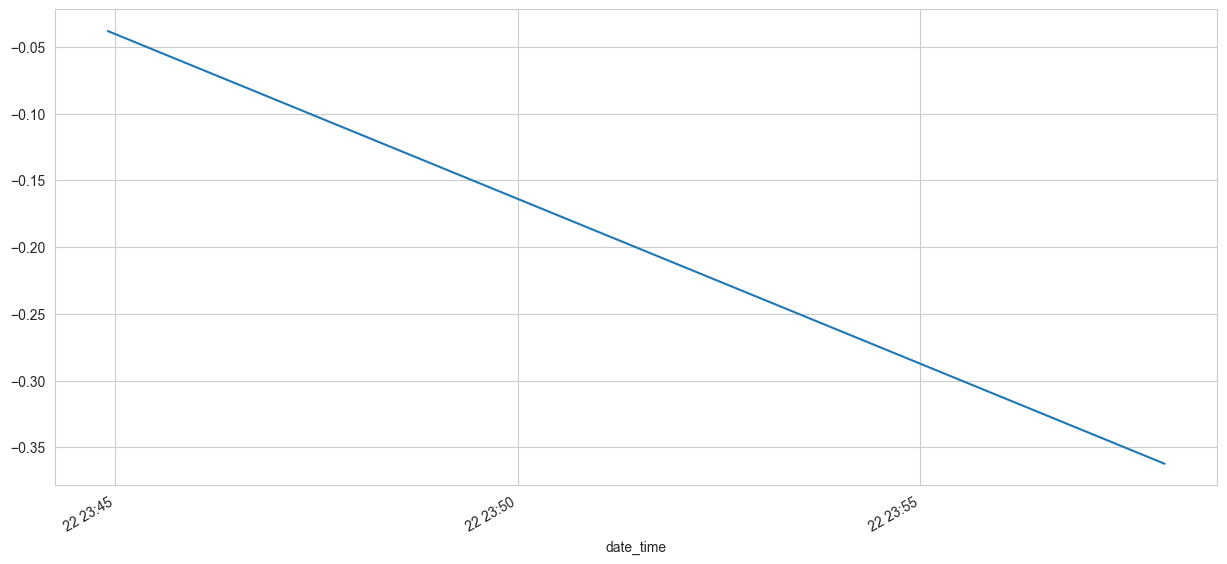

In [63]:
processed_dataset.secundary_multipressure_bar[processed_dataset.secundary_multipressure_bar<0].plot()

La gráfica evidencia como los valores menores a 0 con varios pero la mayoría están muy cerca de cero, se sospecha que el problema es calibraciones del equipo.

In [64]:
processed_dataset.secundary_multipressure_bar[processed_dataset.secundary_multipressure_bar<0].describe()

count    2.000000
mean    -0.200198
std      0.229195
min     -0.362264
25%     -0.281231
50%     -0.200198
75%     -0.119166
max     -0.038133
Name: secundary_multipressure_bar, dtype: float64

In [65]:
IQR = processed_dataset.secundary_multipressure_bar[processed_dataset.secundary_multipressure_bar<0].quantile(0.75) - processed_dataset.secundary_multipressure_bar[processed_dataset.secundary_multipressure_bar<0].quantile(0.25)

LL = processed_dataset.secundary_multipressure_bar[processed_dataset.secundary_multipressure_bar<0].quantile(0.25) -1.5*IQR
LL

np.float64(-0.5243288965)

Se toma la decisión de iterpolar solo los datos que se salen del límite de outliers en los datos menores a cero.

In [66]:
processed_dataset.secundary_multipressure_bar = processed_dataset.secundary_multipressure_bar.mask(processed_dataset.secundary_multipressure_bar < LL, np.nan)
processed_dataset.secundary_multipressure_bar = processed_dataset.secundary_multipressure_bar.interpolate(method="time")

<Axes: xlabel='date_time'>

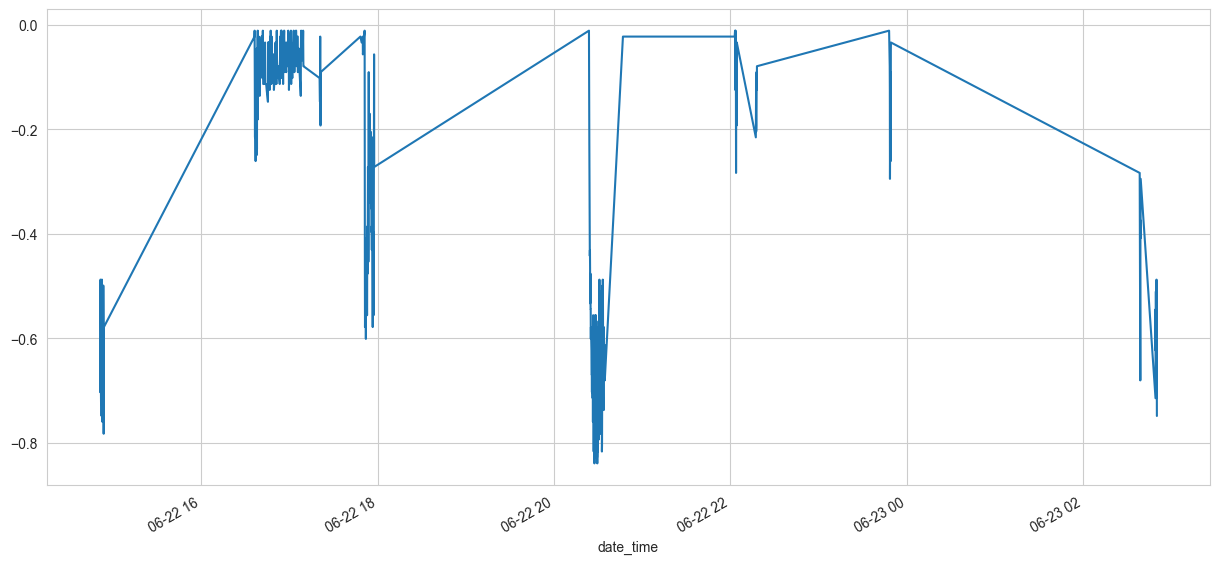

In [67]:
processed_dataset.secundary_p015d1_bar[processed_dataset.secundary_p015d1_bar<0].plot()

La gráfica evidencia como los valores menores a 0 con varios pero la mayoría están muy cerca de cero, se sospecha que el problema es calibraciones del equipo.

In [68]:
processed_dataset.secundary_p015d1_bar[processed_dataset.secundary_p015d1_bar<0].describe()

count    470.000000
mean      -0.342284
std        0.272364
min       -0.839655
25%       -0.601375
50%       -0.283667
75%       -0.079427
max       -0.011347
Name: secundary_p015d1_bar, dtype: float64

In [69]:
IQR = processed_dataset.secundary_p015d1_bar[processed_dataset.secundary_p015d1_bar<0].quantile(0.75) - processed_dataset.secundary_p015d1_bar[processed_dataset.secundary_p015d1_bar<0].quantile(0.25)

LL = processed_dataset.secundary_p015d1_bar[processed_dataset.secundary_p015d1_bar<0].quantile(0.25) -1.5*IQR
LL

np.float64(-1.3842961875000002)

Se toma la decisión de iterpolar solo los datos que se salen del límite de outliers en los datos menores a cero.

In [70]:
processed_dataset.secundary_p015d1_bar = processed_dataset.secundary_p015d1_bar.mask(processed_dataset.secundary_p015d1_bar < LL, np.nan)
processed_dataset.secundary_p015d1_bar = processed_dataset.secundary_p015d1_bar.interpolate(method="time")

#### Descripción Final de los datos

In [71]:
processed_dataset.describe()

,secundary_pumpspeed_rpm,secundary_pa16d1_bar,secundary_p014d1_bar,secundary_p015d1_bar,secundary_pa7b3_mm,secundary_pa4b2_c,secundary_pa4b5_c,secundary_pu2b2_c,secundary_p012b3_c,secundary_p022b3_c,secundary_pa16d6_c,secundary_p014d6_c,secundary_p015d6_c,secundary_multipressure_bar
count,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000,9397.000000
mean,35.818763,30.458714,101.212996,62.641639,314.947707,99.736533,103.333968,99.672502,95.968841,99.585059,101.939715,93.958561,108.926328,18.633485
std,26.695791,4.789479,46.387289,35.740028,161.025781,1.535649,1.784824,1.741329,3.268498,2.567246,1.644463,2.090506,4.846963,11.114114
min,0.000000,4.065357,4.810996,-0.839655,6.672119,86.800000,88.800000,85.300000,73.400000,77.400000,89.100000,82.400000,82.400000,-0.362264
25%,2.376815,29.456007,57.312130,30.976461,169.082400,99.900000,103.300000,99.900000,94.300000,99.800000,102.000000,93.200000,106.100000,14.662142
50%,41.965610,29.990921,128.081440,83.284700,317.041750,100.000000,103.700000,100.000000,96.200000,100.000000,102.200000,94.100000,109.300000,15.157870
75%,56.285040,33.287945,137.272250,90.512540,465.228940,100.100000,103.900000,100.100000,97.900000,100.200000,102.400000,95.100000,111.900000,15.844265
max,80.000000,36.393696,255.788420,219.910190,730.195300,100.800000,105.600000,101.100000,102.500000,101.500000,103.500000,97.100000,123.000000,75.732155


## Lag Features
Vamos a generar un lag de 5. Vamos a usar lag features para darle al modelo una memoria del pasado. Básicamente, creamos nuevas columnas que contienen los valores de la variable de momentos anteriores. Esto es muy importante porque el modelo no entiende el tiempo por sí solo. Al darle estas pistas del pasado, le ayudamos a reconocer patrones y a usar la información anterior para predecir lo que va a suceder.

In [72]:
processed_dataset = processed_dataset.copy()

target_col = "secundary_multipressure_bar"

# Grupos de features según MI
group_A = [
    "secundary_p014d1_bar",
    "secundary_pa7b3_mm",
    "secundary_pa16d1_bar",
    "secundary_p015d1_bar",
    "secundary_pa4b2_c",
    "secundary_p014d6_c"
]

group_B = [
    "secundary_pa16d6_c",
    "secundary_pa4b5_c",
    "secundary_p012b3_c",
    "secundary_pu2b2_c",
    "secundary_p015d6_c",
    "secundary_p022b3_c"
]

group_C = [
    "secundary_pumpspeed_rpm"
]

# Número de lags por grupo
lags_A = 36
lags_B = 36
lags_C = 36

# Función para generar lags de una lista de columnas
def create_lags(df, cols, n_lags):
    for col in cols:
        for lag in range(1, n_lags + 1):
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)

# Crear lags por grupo directamente en processed_dataset
create_lags(processed_dataset, group_A, lags_A)
create_lags(processed_dataset, group_B, lags_B)
create_lags(processed_dataset, group_C, lags_C)

# Crear el target futuro (+12 pasos = ~1 minuto hacia adelante)
processed_dataset["target_plus_12"] = processed_dataset[target_col].shift(-12)

# Eliminar filas con NaN (primeros 36 y últimos 12)
processed_dataset = processed_dataset.dropna()


processed_dataset.shape, processed_dataset.head()


C:\Users\admin\AppData\Local\Temp\ipykernel_4792\1607972340.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}"] = df[col].shift(lag)
C:\Users\admin\AppData\Local\Temp\ipykernel_4792\1607972340.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}"] = df[col].shift(lag)
C:\Users\admin\AppData\Local\Temp\ipykernel_4792\1607972340.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

((9349, 483),
                             secundary_pumpspeed_rpm  secundary_pa16d1_bar  \
 date_time                                                                   
 2023-06-22 14:19:18.792007                41.999100             31.806393   
 2023-06-22 14:19:23.870469                41.204315             31.783699   
 2023-06-22 14:19:28.946102                40.889020             31.816118   
 2023-06-22 14:19:34.030097                39.407448             31.761005   
 2023-06-22 14:19:39.106186                39.635914             31.842052   
 
                             secundary_p014d1_bar  secundary_p015d1_bar  \
 date_time                                                                
 2023-06-22 14:19:18.792007            127.400630              85.06613   
 2023-06-22 14:19:23.870469            127.888535              85.73559   
 2023-06-22 14:19:28.946102            126.595020              84.80516   
 2023-06-22 14:19:34.030097            125.653240              

Los lags usan shift positivo porque miran al pasado, mientras que el target futuro usa shift negativo porque trae el futuro al presente para entrenar el modelo.

In [73]:
print(f"Features generadas después de lags por grupo: {processed_dataset.shape[1]}")

Features generadas después de lags por grupo: 483


## Rolling Means
Lo utilizamos para suavizar las fluctuaciones a corto plazo y resaltar la tendencia subyacente en los datos. Funciona calculando el promedio de un conjunto de puntos dentro de una ventana de tamaño fijo que se desliza a lo largo de toda la serie. Al promediar estos puntos, se reduce el "ruido" o las variaciones aleatorias, lo que permite una visualización más clara de la dirección y los patrones a largo plazo, facilitando así el análisis de la tendencia general.



In [74]:
window_size = 12

processed_dataset['target_MEAN'] = processed_dataset['secundary_multipressure_bar'].shift(1).rolling(window=window_size).mean()
processed_dataset['target_STD'] = processed_dataset['secundary_multipressure_bar'].shift(1).rolling(window=window_size).std()
processed_dataset['target_MIN'] = processed_dataset['secundary_multipressure_bar'].shift(1).rolling(window=window_size).min()
processed_dataset['target_MAX'] = processed_dataset['secundary_multipressure_bar'].shift(1).rolling(window=window_size).max()
processed_dataset = processed_dataset.dropna()

print(f"Features finales: {processed_dataset.shape[1]}")
processed_dataset.head(10)

Features finales: 487


C:\Users\admin\AppData\Local\Temp\ipykernel_4792\2801060484.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_dataset['target_MEAN'] = processed_dataset['secundary_multipressure_bar'].shift(1).rolling(window=window_size).mean()
C:\Users\admin\AppData\Local\Temp\ipykernel_4792\2801060484.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_dataset['target_STD'] = processed_dataset['secundary_multipressure_bar'].shift(1).rolling(window=window_size).std()
C:\Users\admin\AppData\Local\Temp\ipykernel_4792\2801060

,secundary_pumpspeed_rpm,secundary_pa16d1_bar,secundary_p014d1_bar,secundary_p015d1_bar,secundary_pa7b3_mm,secundary_pa4b2_c,secundary_pa4b5_c,secundary_pu2b2_c,secundary_p012b3_c,secundary_p022b3_c,...,secundary_pumpspeed_rpm_lag_32,secundary_pumpspeed_rpm_lag_33,secundary_pumpspeed_rpm_lag_34,secundary_pumpspeed_rpm_lag_35,secundary_pumpspeed_rpm_lag_36,target_plus_12,target_MEAN,target_STD,target_MIN,target_MAX
date_time,,,,,,,,,,,,,,,,,,,,,
2023-06-22 14:20:19.801173,41.080334,31.738312,124.348366,83.205280,28.543823,99.9,103.2,99.9,94.5,100.1,...,28.471409,25.683084,21.831861,21.756290,21.749691,15.005339,15.682200,0.482931,15.062538,16.473460
2023-06-22 14:20:24.866509,40.679600,31.702650,123.735650,82.842180,28.478760,99.9,103.2,99.8,94.6,99.8,...,30.506277,28.471409,25.683084,21.831861,21.756290,15.215070,15.731455,0.442428,15.062538,16.473460
2023-06-22 14:20:29.950502,39.432655,31.660505,123.894500,83.057770,28.446167,99.9,103.2,99.9,94.7,99.7,...,32.320232,30.506277,28.471409,25.683084,21.831861,15.234137,15.698088,0.483945,14.986272,16.473460
2023-06-22 14:20:35.029907,40.503200,31.534071,123.792380,83.443560,28.283447,100.0,103.3,99.9,94.8,99.9,...,35.783356,32.320232,30.506277,28.471409,25.683084,15.100671,15.601167,0.521215,14.890940,16.473460
2023-06-22 14:20:40.101851,41.316950,31.751280,123.849110,82.819490,28.055603,100.0,103.3,99.9,94.9,100.2,...,31.778254,35.783356,32.320232,30.506277,28.471409,14.948139,15.550323,0.514921,14.890940,16.473460
2023-06-22 14:20:45.173293,40.128124,31.689682,123.599490,82.785446,27.827820,100.0,103.3,99.9,95.0,100.2,...,30.558435,31.778254,35.783356,32.320232,30.506277,15.443869,15.464524,0.425056,14.890940,16.320927
2023-06-22 14:20:50.241122,40.182632,31.624846,123.520060,82.796790,27.599976,99.9,103.2,99.9,95.1,100.1,...,31.213974,30.558435,31.778254,35.783356,32.320232,14.910006,15.383491,0.328720,14.890940,15.920531
2023-06-22 14:20:55.316144,40.598020,31.553522,123.259090,82.864876,27.274475,99.9,103.2,99.9,95.2,99.8,...,30.807728,31.213974,30.558435,31.778254,35.783356,14.910006,15.366013,0.343722,14.890940,15.920531
2023-06-22 14:21:00.386923,40.630264,31.585941,122.703100,82.195420,27.274475,99.9,103.3,99.8,95.3,99.6,...,30.262762,30.807728,31.213974,30.558435,31.778254,15.253203,15.270681,0.334463,14.776541,15.844265


## Creación de los conjuntos X & Y

In [75]:
#Conjunto Y
Y = processed_dataset["target_plus_12"]

#Conjunto X
X = processed_dataset.drop(columns=["target_plus_12"])

print("Dimensiones de los conjuntos:")
print(f"X: {X.shape}")
print(f"Y: {Y.shape}")

Dimensiones de los conjuntos:
X: (9337, 486)
Y: (9337,)


In [76]:
print("\n--- Variable Objetivo 'Y' (primeras 5 filas) ---")
Y.head()


--- Variable Objetivo 'Y' (primeras 5 filas) ---


date_time
2023-06-22 14:20:19.801173    15.005339
2023-06-22 14:20:24.866509    15.215070
2023-06-22 14:20:29.950502    15.234137
2023-06-22 14:20:35.029907    15.100671
2023-06-22 14:20:40.101851    14.948139
Name: target_plus_12, dtype: float64

In [77]:
print("\n--- Matriz de Características 'X' (primeras 5 filas) ---")
X.head()


--- Matriz de Características 'X' (primeras 5 filas) ---


,secundary_pumpspeed_rpm,secundary_pa16d1_bar,secundary_p014d1_bar,secundary_p015d1_bar,secundary_pa7b3_mm,secundary_pa4b2_c,secundary_pa4b5_c,secundary_pu2b2_c,secundary_p012b3_c,secundary_p022b3_c,...,secundary_pumpspeed_rpm_lag_31,secundary_pumpspeed_rpm_lag_32,secundary_pumpspeed_rpm_lag_33,secundary_pumpspeed_rpm_lag_34,secundary_pumpspeed_rpm_lag_35,secundary_pumpspeed_rpm_lag_36,target_MEAN,target_STD,target_MIN,target_MAX
date_time,,,,,,,,,,,,,,,,,,,,,
2023-06-22 14:20:19.801173,41.080334,31.738312,124.348366,83.20528,28.543823,99.9,103.2,99.9,94.5,100.1,...,30.506277,28.471409,25.683084,21.831861,21.756290,21.749691,15.682200,0.482931,15.062538,16.47346
2023-06-22 14:20:24.866509,40.679600,31.702650,123.735650,82.84218,28.478760,99.9,103.2,99.8,94.6,99.8,...,32.320232,30.506277,28.471409,25.683084,21.831861,21.756290,15.731455,0.442428,15.062538,16.47346
2023-06-22 14:20:29.950502,39.432655,31.660505,123.894500,83.05777,28.446167,99.9,103.2,99.9,94.7,99.7,...,35.783356,32.320232,30.506277,28.471409,25.683084,21.831861,15.698088,0.483945,14.986272,16.47346
2023-06-22 14:20:35.029907,40.503200,31.534071,123.792380,83.44356,28.283447,100.0,103.3,99.9,94.8,99.9,...,31.778254,35.783356,32.320232,30.506277,28.471409,25.683084,15.601167,0.521215,14.890940,16.47346
2023-06-22 14:20:40.101851,41.316950,31.751280,123.849110,82.81949,28.055603,100.0,103.3,99.9,94.9,100.2,...,30.558435,31.778254,35.783356,32.320232,30.506277,28.471409,15.550323,0.514921,14.890940,16.47346


## Prueba ACF
Utilizamos ACF para determinar si la serie tiene estacionalidad. El objetivo es analizar si presenta algun pico cada n pasos o si no presenta nada, determinamos que no tiene estacionalidad.

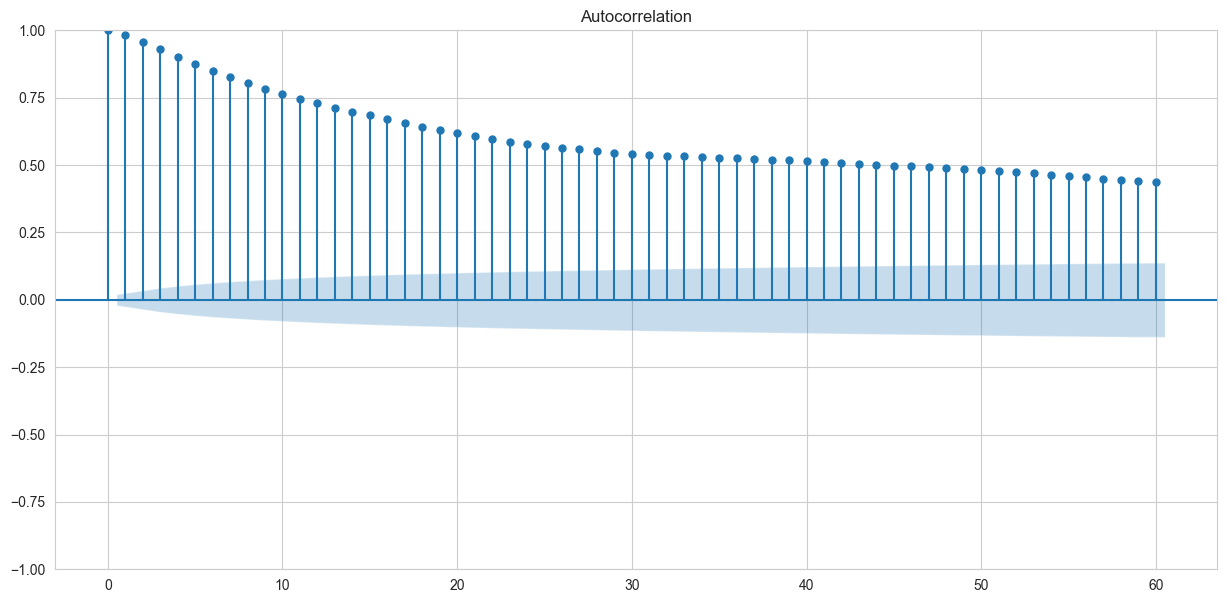

In [78]:
plot_acf(Y, lags = 60)
plt.show()

Los resultados muestran una tendencia descendente, concluyendo que la serie es no es estacionaria. Esto porque no tenemos picos en repetidos en intervalos fijos.

## Prueba PACF

Utilizamos PACF para determinar cuandos periodos pasados afectan el actual y asi definir la variable p en nuestro SARIMAX

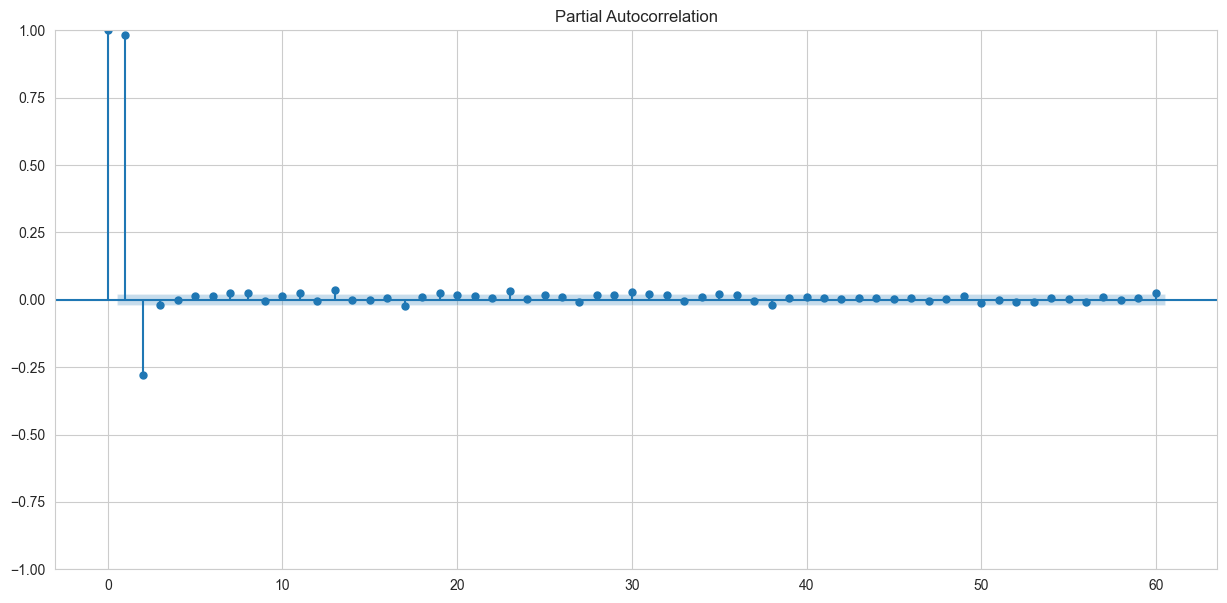

In [79]:
plot_pacf(Y, lags = 60)
plt.show()

El PACF muestra coeficientes claramente significativos solo en los primeros rezagos (lag 1 y, en menor medida, lag 2), mientras que a partir del lag 3 las autocorrelaciones parciales son cercanas a cero.

## Prueba de ADF
Ejecutando la prueba ADF determinamos si la seria de tiempo es estacionaria o no

ADF Statistic: -6.691297
p-value: 0.000000
Estacionaria: True
1%: -3.431
5%: -2.862
10%: -2.567


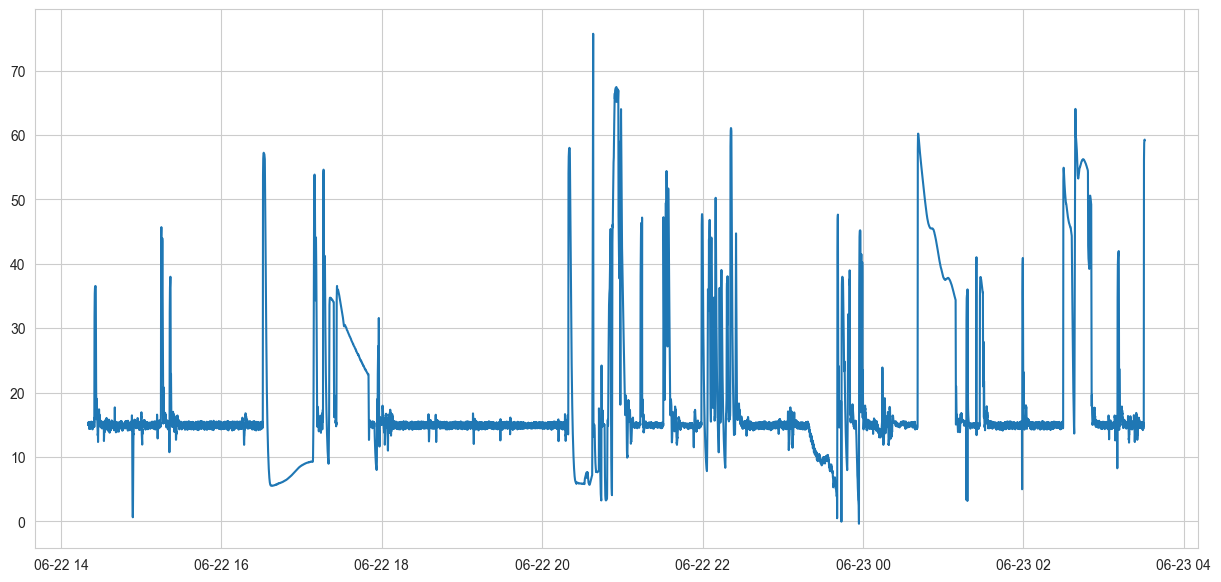

In [80]:
result = adfuller(Y.values)
print(f'ADF Statistic: {result[0]:.6f}')
print(f'p-value: {result[1]:.6f}')
print(f'Estacionaria: {result[1] <= 0.05}')
for key, value in result[4].items():
    print(f'{key}: {value:.3f}')

plt.plot(Y)
plt.show()

Con estos resultados, podemos determinar que nuestra serie temporal es estacionaria, lo cual podemos definir el parámetro p en nuestro SARIMAX como 0

## División del dataset en Train - Test
Vamos a dividir el dataset en 80% Train y 20% Test, en este escenario en particular el orden de los datos si importa, no vamos a utilizar ningún algoritmo que nos haga un shuffle de los datos.

Para esto vamos a utilizar el siguiente algoritmo:
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [81]:
print("Tamaño del dataset original: ", len(processed_dataset))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    shuffle = False,
                                                    random_state = 42)


print("\nTamaño del train: ", len(X_train))
print("\nTamaño del test: ", len(X_test))

Tamaño del dataset original:  9337

Tamaño del train:  7469

Tamaño del test:  1868


## Escalamiento de datos

In [82]:
# Escalado de características
transformer = RobustScaler().fit(X_train)
X_train_scaled = transformer.transform(X_train)
X_test_scaled = transformer.transform(X_test)

## Comparación de Modelos

Vamos a entrenar múltiples modelos para encontrar el mejor desempeño:
- **SARIMAX**: Series temporales con variables exógenas
- **Random Forest**: Ensemble method no paramétrico
- **Gradient Boosting**: Ensemble potente para regresión

In [83]:
# Función mejorada de cálculo de MAPE
def calculate_mape(y_true, y_pred):
    """Calcula MAPE evitando divisiones por cero"""
    mask = y_true != 0
    if mask.sum() == 0:
        return np.inf
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])).mean() * 100

# Función para crear un resumen de métricas
def create_metrics_summary(y_true, y_pred, model_name):
    """Crea un resumen de métricas para un modelo"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = calculate_mape(y_true.values if hasattr(y_true, 'values') else y_true, 
                          y_pred.values if hasattr(y_pred, 'values') else y_pred)
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }

print("Funciones de evaluación definidas correctamente")

Funciones de evaluación definidas correctamente


In [84]:
endog_train = Y_train
endog_test = Y_test
exog_train = X_train_scaled
exog_test = X_test_scaled
seasonal_period = 1

print("=" * 80)
print("Buscando parámetros ARIMA óptimos...")
print("=" * 80)

auto_model = auto_arima(
    endog_train,
    X = exog_train,
    seasonal = False,
    m = seasonal_period,
    test='adf',
    max_p = 2, max_q = 2,
    d = None, D = None,
    max_d = 2,
    stepwise = True,
    trace = True,
    error_action = 'warn',
    suppress_warnings=True
)

order = auto_model.order
seasonal_order = auto_model.seasonal_order

print(f"Orden óptimo (p,d,q): {order}")
print(f"Orden estacional (P,D,Q,m): {seasonal_order}")
print(f"Resumen de auto arima: {auto_model.summary()}")

Buscando parámetros ARIMA óptimos...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=41588.149, Time=265.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54100.102, Time=185.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=41587.709, Time=236.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=48189.716, Time=232.49 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=41649.304, Time=232.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=41585.883, Time=232.62 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=41602.673, Time=234.55 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=41590.145, Time=254.78 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=45426.882, Time=251.89 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=41613.286, Time=236.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 2361.135 seconds
Orden óptimo (p,d,q): (1, 0, 1)
Orden estacional (P,D,Q,m): (0, 0, 0, 0)
Resumen de auto arima:                                SARIMAX Results        

c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w


Métrica                Valor
------------------------------
RMSE                 15.9082
MAE                  11.1286
R²                   -0.3359
MAPE (%)             43.5750


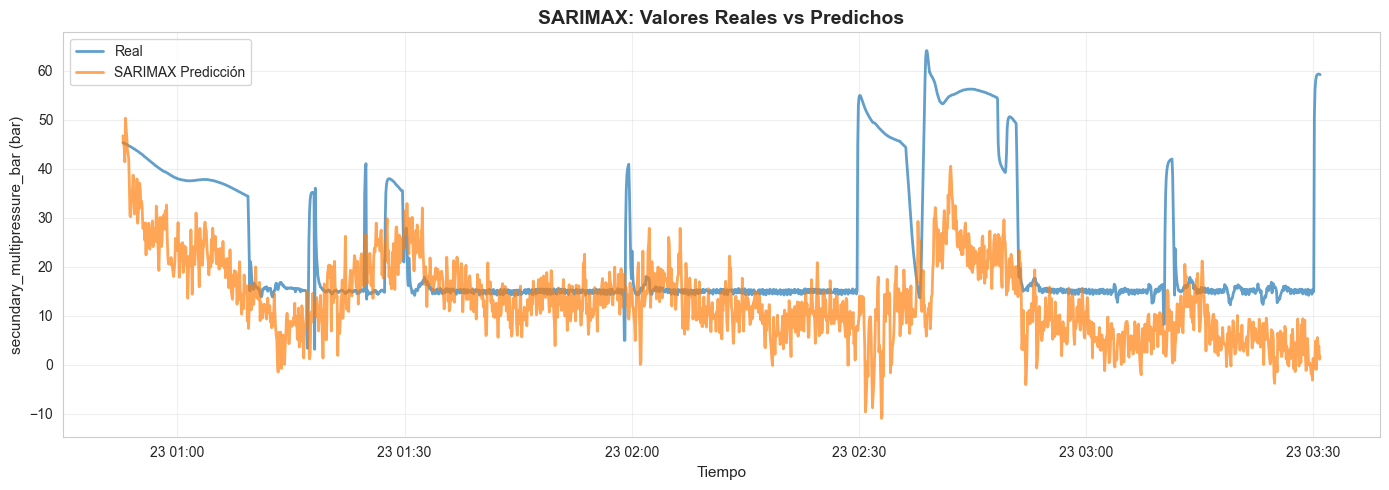

In [85]:
# Entrenar Modelo
model = SARIMAX(endog_train,
                exog = exog_train,
                order = order,
                seasonal_order = seasonal_order,
                enforce_stationarity = False,
                enforce_invertibility = False)

model_fit = model.fit()

# Realizar forecast sobre el conjunto de test
n_steps = len(endog_test)
forecast_res = model_fit.get_forecast(steps = n_steps, exog = exog_test)
y_pred_sarimax = forecast_res.predicted_mean

# Métricas SARIMAX
sarimax_metrics = create_metrics_summary(endog_test, y_pred_sarimax, "SARIMAX")

print(f"\n{'Métrica':<15} {'Valor':>12}")
print("-" * 30)
for key, value in sarimax_metrics.items():
    if key != 'Model':
        if isinstance(value, float):
            print(f"{key:<15} {value:>12.4f}")
            
# Visualización SARIMAX
plt.figure(figsize=(14, 5))
plt.plot(endog_test.index, endog_test.values, label='Real', linewidth=2, alpha=0.7)
plt.plot(endog_test.index, y_pred_sarimax.values, label='SARIMAX Predicción', linewidth=2, alpha=0.7)
plt.title('SARIMAX: Valores Reales vs Predichos', fontsize=14, fontweight='bold')
plt.xlabel('Tiempo', fontsize=11)
plt.ylabel('secundary_multipressure_bar (bar)', fontsize=11)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [86]:

# 2. RANDOM FOREST REGRESSOR
print("\n" + "=" * 80)
print("2. MODELO RANDOM FOREST")
print("=" * 80)

rf_base = RandomForestRegressor(
    random_state = 42,
    n_jobs = -1
)

# Definir espacio de búsqueda de hiperparámetros
param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [8, 12, 16, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

# TimeSeriesSplit para respetar el orden temporal
tscv = TimeSeriesSplit(n_splits = 5)

print("\nBuscando mejores hiperparámetros para Random Forest...")
rf_search = RandomizedSearchCV(
    estimator = rf_base,
    param_distributions = param_dist,
    n_iter = 20,                 
    scoring = "r2",              
    cv = tscv,
    n_jobs = -1,
    verbose = 2,
    random_state = 42
)

# Ajuste solo con datos de entrenamiento
rf_search.fit(X_train_scaled, Y_train)

print("\nMejores hiperparámetros encontrados:")
print(rf_search.best_params_)

# Modelo final: mejor estimador encontrado
rf_model = rf_search.best_estimator_

print("\nEntrenando Random Forest final con los mejores hiperparámetros...")
rf_model.fit(X_train_scaled, Y_train)

# Predicción sobre el conjunto de test
y_pred_rf = rf_model.predict(X_test_scaled)

# Métricas
rf_metrics = create_metrics_summary(Y_test, y_pred_rf, "Random Forest")

print(f"\n{'Métrica':<15} {'Valor':>12}")
print("-" * 30)
for key, value in rf_metrics.items():
    if key != 'Model':
        if isinstance(value, float):
            print(f"{key:<15} {value:>12.4f}")

# Importancia de variables (Top 15)
feature_importance_rf = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
feature_importance_rf.plot(kind='barh', color='steelblue')
plt.title('Top 15 Features - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importancia', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Visualización serie real vs predicción
plt.figure(figsize=(14, 5))
plt.plot(Y_test.index, Y_test.values, label='Real', linewidth=2, alpha=0.7)
plt.plot(Y_test.index, y_pred_rf, label='RF Predicción', linewidth=2, alpha=0.7)
plt.title('Random Forest: Valores Reales vs Predichos', fontsize=14, fontweight='bold')
plt.xlabel('Tiempo', fontsize=11)
plt.ylabel('secundary_multipressure_bar (bar)', fontsize=11)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


2. MODELO RANDOM FOREST

Buscando mejores hiperparámetros para Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
print("\n" + "=" * 80)
print("3. MODELO GRADIENT BOOSTING")
print("=" * 80)

# Modelo base
gb_base = GradientBoostingRegressor(
    random_state = 42
)

# Espacio de búsqueda de hiperparámetros
gb_param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 6],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "subsample": [0.7, 0.8, 1.0],
    "max_features": ["sqrt", "log2", None]
}

# TimeSeriesSplit para respetar la estructura temporal
tscv = TimeSeriesSplit(n_splits = 5)

print("\nBuscando mejores hiperparámetros para Gradient Boosting...")
gb_search = RandomizedSearchCV(
    estimator = gb_base,
    param_distributions = gb_param_dist,
    n_iter = 20,                
    scoring = "r2",
    cv = tscv,
    n_jobs = -1,
    verbose = 2,
    random_state = 42
)

gb_search.fit(X_train_scaled, Y_train)

print("\nMejores hiperparámetros encontrados (GB):")
print(gb_search.best_params_)

gb_model = gb_search.best_estimator_

print("\nEntrenando Gradient Boosting final con los mejores hiperparámetros...")
gb_model.fit(X_train_scaled, Y_train)

y_pred_gb = gb_model.predict(X_test_scaled)

# Métricas
gb_metrics = create_metrics_summary(Y_test, y_pred_gb, "Gradient Boosting")

print(f"\n{'Métrica':<15} {'Valor':>12}")
print("-" * 30)
for key, value in gb_metrics.items():
    if key != 'Model':
        if isinstance(value, float):
            print(f"{key:<15} {value:>12.4f}")

# Importancia de variables (Top 15)
feature_importance_gb = pd.Series(
    gb_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
feature_importance_gb.plot(kind='barh', color='forestgreen')
plt.title('Top 15 Features - Gradient Boosting', fontsize=14, fontweight='bold')
plt.xlabel('Importancia', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Visualización serie real vs predicción
plt.figure(figsize=(14, 5))
plt.plot(Y_test.index, Y_test.values, label='Real', linewidth=2, alpha=0.7)
plt.plot(Y_test.index, y_pred_gb, label='GB Predicción', linewidth=2, alpha=0.7)
plt.title('Gradient Boosting: Valores Reales vs Predichos', fontsize=14, fontweight='bold')
plt.xlabel('Tiempo', fontsize=11)
plt.ylabel('secundary_multipressure_bar (bar)', fontsize=11)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Resultados

In [ ]:

# COMPARACIÓN DE MODELOS
print("\n" + "=" * 80)
print("COMPARACIÓN GENERAL DE MODELOS")
print("=" * 80)

# Crear tabla comparativa
results_list = [sarimax_metrics, rf_metrics, gb_metrics]


results_df = pd.DataFrame(results_list)
print("\n")
print(results_df.to_string(index=False))

# Encontrar mejor modelo por cada métrica
print("\n" + "-" * 80)
print("MEJOR MODELO POR MÉTRICA:")
print("-" * 80)

metrics_cols = ['RMSE', 'MAE', 'R²', 'MAPE (%)']
for metric in metrics_cols:
    if metric == 'R²':  # Maximizar R²
        best_idx = results_df[metric].idxmax()
    else:  # Minimizar otros
        best_idx = results_df[metric].idxmin()
    
    best_model = results_df.loc[best_idx, 'Model']
    best_value = results_df.loc[best_idx, metric]
    print(f"{metric:<15}: {best_model:<20} = {best_value:.4f}")

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparación de Desempeño de Modelos', fontsize=16, fontweight='bold')

# RMSE
ax = axes[0, 0]
results_df.plot(x='Model', y='RMSE', kind='bar', ax=ax, color='steelblue', legend=False)
ax.set_title('RMSE (menor es mejor)', fontweight='bold')
ax.set_ylabel('RMSE')
ax.set_xlabel('')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# MAE
ax = axes[0, 1]
results_df.plot(x='Model', y='MAE', kind='bar', ax=ax, color='forestgreen', legend=False)
ax.set_title('MAE (menor es mejor)', fontweight='bold')
ax.set_ylabel('MAE')
ax.set_xlabel('')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# R²
ax = axes[1, 0]
results_df.plot(x='Model', y='R²', kind='bar', ax=ax, color='coral', legend=False)
ax.set_title('R² (mayor es mejor)', fontweight='bold')
ax.set_ylabel('R²')
ax.set_xlabel('')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# MAPE
ax = axes[1, 1]
results_df.plot(x='Model', y='MAPE (%)', kind='bar', ax=ax, color='mediumpurple', legend=False)
ax.set_title('MAPE (menor es mejor)', fontweight='bold')
ax.set_ylabel('MAPE (%)')
ax.set_xlabel('')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:

# ANÁLISIS DE RESIDUOS - MEJOR MODELO
print("\n" + "=" * 80)
print("ANÁLISIS DE RESIDUOS")
print("=" * 80)

# Identificar mejor modelo por R²
best_r2_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_r2_idx, 'Model']

if best_model_name == 'SARIMAX':
    y_pred_best = y_pred_sarimax
    y_test_best = endog_test
    print(f"\nMejor modelo: {best_model_name} (R² = {results_df.loc[best_r2_idx, 'R²']:.4f})")
elif best_model_name == 'Random Forest':
    y_pred_best = y_pred_rf
    y_test_best = Y_test
    print(f"\nMejor modelo: {best_model_name} (R² = {results_df.loc[best_r2_idx, 'R²']:.4f})")
elif best_model_name == 'Gradient Boosting':
    y_pred_best = y_pred_gb
    y_test_best = Y_test
    print(f"\nMejor modelo: {best_model_name} (R² = {results_df.loc[best_r2_idx, 'R²']:.4f})")
else:  # XGBoost
    #y_pred_best = y_pred_xgb
    y_test_best = Y_test
    print(f"\nMejor modelo: {best_model_name} (R² = {results_df.loc[best_r2_idx, 'R²']:.4f})")

# Calcular residuos
residuos = y_test_best.values - y_pred_best if hasattr(y_test_best, 'values') else y_test_best - y_pred_best

# Análisis estadístico de residuos
print(f"\nEstadísticas de residuos:")
print(f"  Media: {residuos.mean():.6f}")
print(f"  Desv. Est.: {residuos.std():.6f}")
print(f"  Min: {residuos.min():.6f}")
print(f"  Max: {residuos.max():.6f}")

# Visualización de residuos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Análisis de Residuos - {best_model_name}', fontsize=16, fontweight='bold')

# Residuos en el tiempo
ax = axes[0, 0]
ax.plot(residuos, linewidth=1, alpha=0.7)
ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.set_title('Residuos en el Tiempo')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Residuo')
ax.grid(True, alpha=0.3)

# Histograma de residuos
ax = axes[0, 1]
ax.hist(residuos, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax.set_title('Distribución de Residuos')
ax.set_xlabel('Residuo')
ax.set_ylabel('Frecuencia')
ax.grid(True, alpha=0.3, axis='y')

# Q-Q plot
from scipy import stats
ax = axes[1, 0]
stats.probplot(residuos, dist="norm", plot=ax)
ax.set_title('Q-Q Plot (Normalidad)')
ax.grid(True, alpha=0.3)

# Residuos vs Predichos
ax = axes[1, 1]
ax.scatter(y_pred_best, residuos, alpha=0.5)
ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.set_title('Residuos vs Valores Predichos')
ax.set_xlabel('Valores Predichos')
ax.set_ylabel('Residuos')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test de normalidad Shapiro-Wilk
if len(residuos) <= 5000:
    from scipy.stats import shapiro
    stat, p_value = shapiro(residuos)
    print(f"\nTest Shapiro-Wilk (normalidad de residuos):")
    print(f"  Estadístico: {stat:.6f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Resultado: {'Residuos son normales' if p_value > 0.05 else 'Residuos NO son normales'}")